In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.image import grid_to_graph
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from matplotlib.colors import Normalize
import cv2
import tqdm

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
fly = '339'

In [3]:
dataset_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset'
load_directory = os.path.join(dataset_path,F'fly_{fly}/func_0')
file = os.path.join(load_directory, 'functional_channel_1_moco_zscore_highpass.h5')

with h5py.File(file, 'r') as hf:
    print(hf['data'].shape)
    data = hf['data'][:]

(130, 31, 11, 17588)


In [4]:
dims = {'x':data.shape[0],
        'y':data.shape[1],
        'z':data.shape[2],
        't':data.shape[3]}

In [5]:
timestamps = brainsss.load_timestamps(os.path.join(load_directory, 'imaging'))

fictrac_raw = brainsss.load_fictrac(os.path.join(load_directory, 'fictrac'))
resolution = 10 #desired resolution in ms
fps = 100
expt_len = fictrac_raw.shape[0]/fps*1000
fictrac_raw.shape

Trying to load timestamp data from hdf5 file.
Success.


(182788, 25)

In [6]:
behaviors = ['dRotLabZneg', 'dRotLabZpos', 'dRotLabY']
fictrac = {}
z=5
for behavior,short in zip(behaviors,['R','L','F']):
    fictrac_interp = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps=timestamps, z=z)
    fictrac[short] = fictrac_interp

In [7]:
### MAKE CLUSTER DIRECTORY ###
cluster_dir = os.path.join(load_directory, 'clustering')
if not os.path.exists(cluster_dir):
    os.mkdir(cluster_dir)

### FIT CLUSTERS ###
n_clusters = 400

connectivity = grid_to_graph(dims['x'],dims['y'],dims['z'])
neural_activity = data.reshape(-1, dims['t'])
cluster_model = AgglomerativeClustering(n_clusters=n_clusters,
                            memory=cluster_dir,
                            linkage='ward',
                            connectivity=connectivity)
cluster_model.fit(neural_activity)
cluster_labels = cluster_model.labels_

/home/users/brezovec/.local/lib/python3.6/site-packages/sklearn/cluster/_hierarchical.py:856: UserWarning: Persisting input arguments took 4.02s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **kwargs)


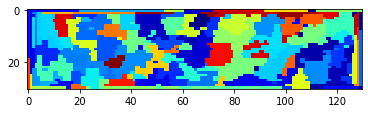

In [8]:
cluster_labels_3d = np.reshape(cluster_labels,(dims['x'],dims['y'],dims['z']))
plt.imshow(cluster_labels_3d[:,:,7].T,cmap='jet')

In [9]:
### GET CLUSTER AVERAGE SIGNAL ###
signals = []
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_labels==cluster_num)[0]
    mean_signal = np.mean(neural_activity[cluster_indicies,:], axis=0)
    signals.append(mean_signal)
signals = np.nan_to_num(np.asarray(signals)).astype('float64')
print(signals.shape)

(400, 17588)


In [10]:
sym_filter = []
for cluster_num in range(n_clusters):
    cc_R = scipy.signal.correlate(signals[cluster_num,:], fictrac['R'])
    cc_L = scipy.signal.correlate(signals[cluster_num,:], fictrac['L'])
    sym_filter.append(cc_R-cc_L)
sym_filter = np.asarray(sym_filter)
sym_filter.shape

(400, 35175)

In [12]:
timestep = np.diff(timestamps[:,0])[0] #is units of ms
window_30s = int(1000*30/timestep)

In [169]:
15000/timestep

143.15263716742544

In [74]:
timestep*t[0]

-14669.656399999998

In [89]:
np.arange(-140,2,2)

array([-140, -138, -136, -134, -132, -130, -128, -126, -124, -122, -120,
       -118, -116, -114, -112, -110, -108, -106, -104, -102, -100,  -98,
        -96,  -94,  -92,  -90,  -88,  -86,  -84,  -82,  -80,  -78,  -76,
        -74,  -72,  -70,  -68,  -66,  -64,  -62,  -60,  -58,  -56,  -54,
        -52,  -50,  -48,  -46,  -44,  -42,  -40,  -38,  -36,  -34,  -32,
        -30,  -28,  -26,  -24,  -22,  -20,  -18,  -16,  -14,  -12,  -10,
         -8,   -6,   -4,   -2,    0])

In [153]:
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20240126_movie_337'
os.mkdir(save_path)

In [154]:
for k,t in tqdm.tqdm(enumerate(np.arange(-140,2,2))):

    empty = np.zeros(cluster_labels.shape)
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(cluster_labels==cluster_num)[0]
        empty[cluster_indicies] = sym_filter[cluster_num,dims['t']+t]
    empty = np.reshape(empty,(dims['x'],dims['y'],dims['z']))

    plt.figure(figsize=(10,20))
    for z in range(dims['z']):
        plt.subplot(dims['z'],1,z+1)
        plt.imshow(empty[:,:,z].T,cmap='seismic',vmax=10000,vmin=-10000)
        plt.axis('off')
    plt.suptitle(F"Time: {int(t*timestep)}ms",y=.89)
    
    fname = os.path.join(save_path, '{0:05d}.png'.format(k))
    plt.savefig(fname,dpi=100,bbox_inches='tight')
    plt.clf()

20it [00:12,  1.54it/s]/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
71it [00:45,  1.57it/s]


<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

Text(0.5, 0.89, 'Time: 0')

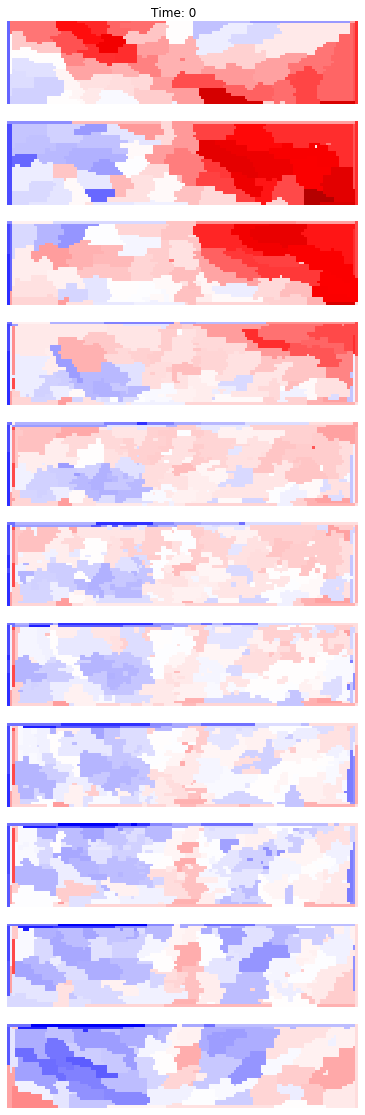

In [16]:
t=0

empty = np.zeros(cluster_labels.shape)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_labels==cluster_num)[0]
    empty[cluster_indicies] = sym_filter[cluster_num,dims['t']-100]
empty = np.reshape(empty,(dims['x'],dims['y'],dims['z']))

plt.figure(figsize=(10,20))
for z in range(dims['z']):
    plt.subplot(dims['z'],1,z+1)
    plt.imshow(empty[:,:,z].T,cmap='seismic',vmax=50000,vmin=-50000)
    plt.axis('off')
plt.suptitle(F"Time: {int(t)}",y=.89)

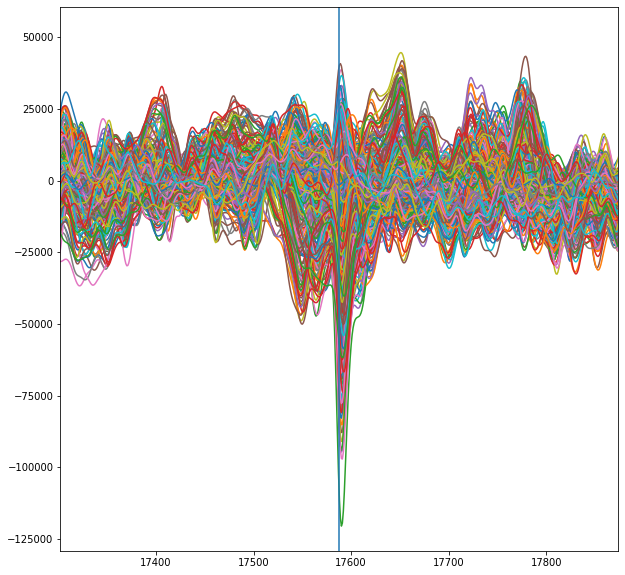

In [13]:
plt.figure(figsize=(10,10))
plt.axhline(0,color='k',lw=2)
clusters = []
cnt = 0
for cluster_num in range(n_clusters):
    #if np.abs(sym_filter[cluster_num,dims['t']]) > 30000:
    smo = gaussian_filter1d(sym_filter[cluster_num,:],4)
    if np.abs(np.mean(smo[dims['t']-100:dims['t']-30])) > 0:
        plt.plot(smo)#+40000*cnt)
        clusters.append(cluster_num)
        #plt.axhline(40000*cnt,color='k')
        cnt+=1

#plt.plot(sym_filter[hemi][117,:],color='k')

plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'])

17302

In [117]:
sym_filter_smo = gaussian_filter1d(sym_filter,4,axis=1)[:,dims['t']-window_30s:dims['t']+window_30s]

In [118]:
sym_filter_smo.shape

(400, 572)

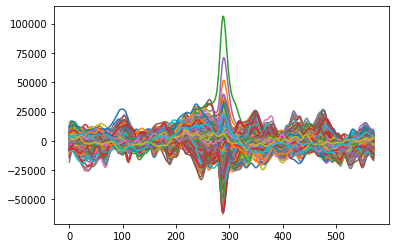

In [119]:
for i in range(400):
    plt.plot(sym_filter_smo[i,:])

In [138]:
n_clusters = 10
cluster_model = AgglomerativeClustering(n_clusters=n_clusters,
                            memory=cluster_dir,
                            linkage='ward',
                            connectivity=None)
cluster_model.fit(sym_filter_smo)
cluster_labels = cluster_model.labels_

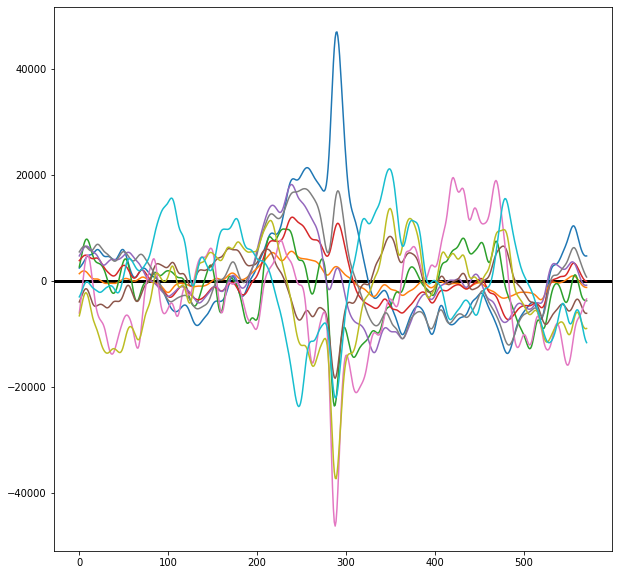

In [139]:
plt.figure(figsize=(10,10))
c_mean = []
plt.axhline(0,color='k',lw=3)
for c in range(n_clusters):
    c_mean = np.mean(sym_filter_smo[np.where(cluster_labels == c)[0],:],axis=0)
    plt.plot(c_mean)

In [126]:
np.mean(sym_filter_smo[np.where(cluster_labels == 0),:],axis=1).shape

(1, 572)

In [129]:
np.where(cluster_labels == 0)[0]

array([ 30,  41, 121, 179, 224, 242, 281, 300, 312, 374])

(17302, 17874)

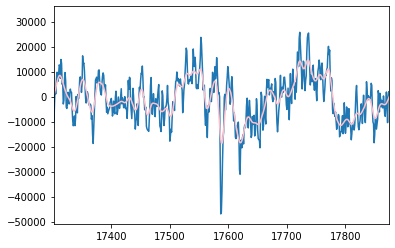

In [114]:
plt.plot(sym_filter[117,:])
plt.plot(sym_filter_smo[117,:],color='pink')
plt.xlim(dims['t']-window_30s,dims['t']+window_30s)


In [27]:
maxs = np.max(np.asarray(empty),axis=-1)
mins = np.min(np.asarray(empty),axis=-1)
maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
roi_datas = maxs
roi_datas.shape

(130, 31)

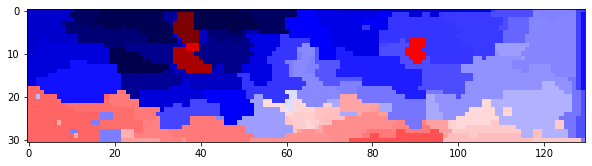

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(roi_datas.T,cmap='seismic',vmax=100000,vmin=-100000)

In [91]:
plt.figure(figsize=(10,10))
hemi = 'L'
clusters = []
cnt = 0
for cluster_num in range(n_clusters): 
    if np.abs(sym_filter[hemi][cluster_num,dims['t']]) > 30000:
        if np.abs(np.mean(sym_filter[hemi][cluster_num,dims['t']-100:dims['t']-30])) > 5000:
            plt.plot(sym_filter[hemi][cluster_num,:])#+40000*cnt)
            clusters.append(cluster_num)
            #plt.axhline(40000*cnt,color='k')
            cnt+=1

plt.plot(sym_filter[hemi][117,:],color='k')

plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<Figure size 720x720 with 0 Axes>

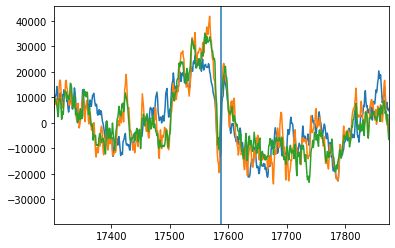

In [161]:
plt.plot(sym_filter[hemi][117,:])
plt.plot(sym_filter[hemi][110,:])
plt.plot(sym_filter[hemi][59,:])


plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'])

In [138]:
sym_filter[hemi].shape

(200, 35175)

In [141]:
np.mean(sym_filter[hemi][:,dims['t']-100:dims['t']-30],axis=1).shape

(200,)

In [159]:
np.argsort(np.mean(sym_filter[hemi][:,dims['t']-100:dims['t']-30],axis=1))

array([164, 105, 158, 149, 177, 153, 192, 159, 137,   3,  44, 189,  46,
       107, 173, 178, 172, 165, 139, 141, 130,  65,  60, 112, 157, 163,
         0,  53, 125,  84, 103, 169, 166, 182,  18, 104,  14, 188,   5,
       167, 145,  55,  95, 135,  49,  23,  99, 148, 179,  83, 115, 196,
        47,  90,  85,  81,  74,  24,  77, 116, 161,  36,  80, 136, 171,
       101,  56,  21, 191,  16,   4,  98,  26, 142,  42, 140,  68,  91,
        78,  28,  40,  69,  17,   6,  12,  37, 152, 138,  76, 195, 102,
       194,  96, 127, 198, 183,  50,  38,   7,  54,  64,  67, 184,  58,
       129, 156,  97,  30,  10,  62,  45, 100, 150,  88, 151, 121,  48,
       133, 111,  61, 118,  94, 128, 113, 190, 122,  29, 124,  13, 126,
        87,  35,  86,  71,  66,  27, 109, 197, 123,  93,  82,   8, 181,
        57,  25,  51, 155,  70, 144, 120, 134,  41, 187, 162, 132,   2,
        19, 186, 174, 199, 106,  72,  31, 143, 147,  11, 154, 176, 131,
        32,  52, 114,  92,   9, 193,  63,   1, 168, 175,  33, 17

In [ ]:
plt.figure(figsize=(10,10))
hemi = 'L'
clusters = []
cnt = 0

thresh = np.percentile(np.abs(sym_filter[hemi][:,dims['t']]),80)

for cluster_num in range(n_clusters): 
    if np.abs(sym_filter[hemi][cluster_num,dims['t']]) > thresh:
        if np.abs(np.mean(sym_filter[hemi][cluster_num,dims['t']-100:dims['t']-30])) > 5000:
            plt.plot(sym_filter[hemi][cluster_num,:]+40000*cnt)
            clusters.append(cluster_num)
            plt.axhline(40000*cnt,color='k')
            cnt+=1

plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'])

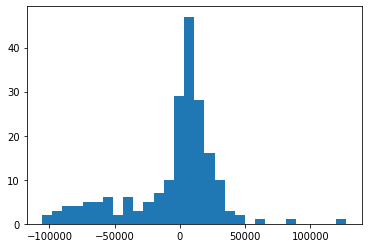

In [127]:
plt.hist(sym_filter['L'][:,dims['t']],bins=30);

In [131]:
thresh = np.percentile(np.abs(sym_filter['L'][:,dims['t']]),80)

40336.3736401095

In [109]:
clusters

[2, 34, 43, 72, 105, 119, 132, 144, 146, 151, 164, 170, 176]

In [145]:
empty = np.zeros(labels[hemi].shape)
for c in [117]:
    empty[np.where(labels[hemi]==c)[0]] = 1
empty = np.reshape(empty,(data_hemi[hemi].shape[0],dims['y'],dims['z']))

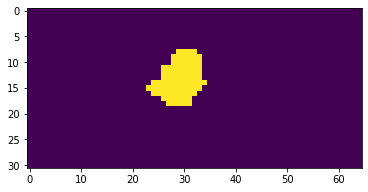

In [146]:
plt.imshow(np.max(empty,axis=-1).T)

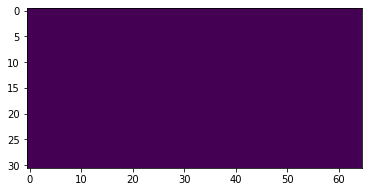

In [156]:
plt.imshow(empty[:,:,10].T)

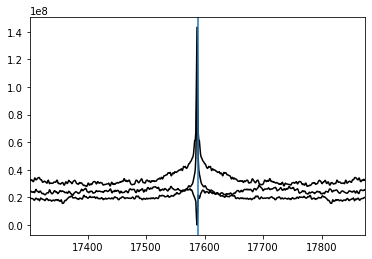

In [98]:
cc = scipy.signal.correlate(fictrac['L'], fictrac['R'])
plt.plot(cc,color='k')

cc = scipy.signal.correlate(fictrac['L'], fictrac['L'])
plt.plot(cc,color='k')

cc = scipy.signal.correlate(fictrac['R'], fictrac['R'])
plt.plot(cc,color='k')

plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'])